In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gtfparse import read_gtf
import bioframe
from matplotlib_venn import venn2, venn2_circles
import warnings
warnings.filterwarnings('ignore')

## Count which peaks are present in each dataset

In [3]:
mouse_zfp143_peaks = pd.read_csv('./peaks/mouse_ZFP143_all_peaks.merged.motifs.bed', 
                                 sep = '\t', header = None)
mouse_zfp143_peaks.columns = ['chrom', 'start', 'end', 'sbs1', 'sbs2']
mouse_zfp143_peaks['sbs1'] = np.sign(mouse_zfp143_peaks['sbs1'])
mouse_zfp143_peaks['sbs2'] = np.sign(mouse_zfp143_peaks['sbs2'])
mouse_zfp143_peaks['sbs1_and_sbs2'] = [1 if x==2 else 0 for x in mouse_zfp143_peaks['sbs1']+mouse_zfp143_peaks['sbs2']]
mouse_zfp143_peaks['sbs1_or_sbs2'] = np.sign(mouse_zfp143_peaks['sbs1']+mouse_zfp143_peaks['sbs2'])
sbs_motifs_data = mouse_zfp143_peaks[['sbs1', 'sbs2', 'sbs1_and_sbs2', 'sbs1_or_sbs2']]
mouse_zfp143_peaks = mouse_zfp143_peaks.drop(['sbs1', 'sbs2', 'sbs1_and_sbs2', 'sbs1_or_sbs2'], axis = 1)

mouse_zfp143_peaks.head()

,chrom,start,end
0,chr1,3670924,3671134
1,chr1,4490609,4490825
2,chr1,4491617,4492823
3,chr1,4493210,4493821
4,chr1,4494100,4494487


In [5]:
znf143_peaks = sorted(os.listdir('./peaks/'))
znf143_peaks = [x for x in znf143_peaks if '.bed' in x and 'Zfp143' in x and 'human' not in x and 'mouse' not in x and 'qvalue' not in x and 'reanalysis' not in x]

for peak_set in znf143_peaks:
    name_dataset = peak_set.replace('_Zfp143_ChIPseq', '').replace('.bed', '').replace('_WT_', '_HSPC_')
    name_dataset = name_dataset.replace('_3T3', '_Fibroblasts_3T3').replace('_MEF', '_Fibroblasts_MEF')
    znf143_peaks_dataset = pd.read_csv('./peaks/' + peak_set, sep = '\t', header = None)
    znf143_peaks_dataset = znf143_peaks_dataset[[0, 1, 2, 3, 4, 5]]
    znf143_peaks_dataset.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
    mouse_zfp143_peaks = bioframe.count_overlaps(mouse_zfp143_peaks, znf143_peaks_dataset)
    mouse_zfp143_peaks.columns = list(mouse_zfp143_peaks.columns[:-1]) + [name_dataset]
    mouse_zfp143_peaks[name_dataset] = np.sign(mouse_zfp143_peaks[name_dataset])

mouse_zfp143_peaks['total'] = mouse_zfp143_peaks.drop(['chrom', 'start', 'end'], axis = 1).sum(axis = 1).values
mouse_zfp143_peaks.head()

,chrom,start,end,Jung_Sperm_rep1,Jung_Sperm_rep2,Ngondo-Mbongo_Fibroblasts_3T3,Ngondo-Mbongo_Fibroblasts_MEF,Ngondo-Mbongo_mESC,Zhou_HSPC_rep1,Zhou_HSPC_rep2,total
0,chr1,3670924,3671134,0,0,0,0,0,1,0,1
1,chr1,4490609,4490825,0,0,0,0,0,1,0,1
2,chr1,4491617,4492823,0,0,0,0,0,1,0,1
3,chr1,4493210,4493821,0,0,0,0,0,1,0,1
4,chr1,4494100,4494487,0,0,0,0,0,1,0,1


## Count antibody-specific and cell-type-specific peaks

In [6]:
cell_lines = ['Sperm', 'HSPC', 'mESC', 'MEF', '3T3']

# Count peaks present only in one cell type
cell_line_specific_peaks = np.zeros(len(mouse_zfp143_peaks))
for cell_line in cell_lines:
    cell_line_specific_index = []
    cell_line_peak_counts = mouse_zfp143_peaks[[x for x in mouse_zfp143_peaks.columns if cell_line in x]].sum(axis = 1)
    for i in range(0, len(cell_line_peak_counts)):
        if cell_line_peak_counts[i] == mouse_zfp143_peaks['total'].values[i]:
            cell_line_specific_index.append(1)
        else:
            cell_line_specific_index.append(0)
    cell_line_specific_peaks = cell_line_specific_peaks + np.array(cell_line_specific_index)
mouse_zfp143_peaks['cell_line_specific'] = np.sign(cell_line_specific_peaks)

# Count peaks present in all cell types
cell_line_specific_peaks = np.zeros(len(mouse_zfp143_peaks))
for cell_line in cell_lines:
    cell_line_specific_index = []
    cell_line_peak_counts = mouse_zfp143_peaks[[x for x in mouse_zfp143_peaks.columns if cell_line in x]].sum(axis = 1)
    cell_line_specific_peaks = cell_line_specific_peaks + np.sign(cell_line_peak_counts)    
mouse_zfp143_peaks['conserved'] = [1 if x == 5 else 0 for x in cell_line_specific_peaks]

In [7]:
mouse_zfp143_peaks = pd.concat([mouse_zfp143_peaks, sbs_motifs_data], axis = 1)
mouse_zfp143_peaks.head()

,chrom,start,end,Jung_Sperm_rep1,Jung_Sperm_rep2,Ngondo-Mbongo_Fibroblasts_3T3,Ngondo-Mbongo_Fibroblasts_MEF,Ngondo-Mbongo_mESC,Zhou_HSPC_rep1,Zhou_HSPC_rep2,total,cell_line_specific,conserved,sbs1,sbs2,sbs1_and_sbs2,sbs1_or_sbs2
0,chr1,3670924,3671134,0,0,0,0,0,1,0,1,1.0,0,0,0,0,0
1,chr1,4490609,4490825,0,0,0,0,0,1,0,1,1.0,0,0,0,0,0
2,chr1,4491617,4492823,0,0,0,0,0,1,0,1,1.0,0,1,0,0,1
3,chr1,4493210,4493821,0,0,0,0,0,1,0,1,1.0,0,0,0,0,0
4,chr1,4494100,4494487,0,0,0,0,0,1,0,1,1.0,0,0,0,0,0


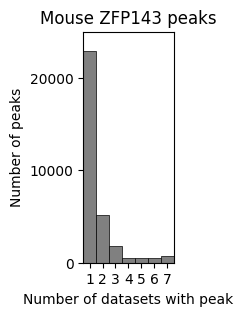

In [8]:
plt.figure(figsize = (5*7/30, 3))
plt.title('Mouse ZFP143 peaks', fontsize = 12)
plt.bar(np.unique(mouse_zfp143_peaks['total'], return_counts = 1)[0],
        np.unique(mouse_zfp143_peaks['total'], return_counts = 1)[1], 
        edgecolor = 'k', color = 'grey', linewidth = 0.5, width = 1)
plt.xlim((0.5, 7.5))
plt.ylim((0, 25000))
plt.xticks(np.arange(1, 8))
plt.yticks([0, 10000, 20000])
plt.xlabel('Number of datasets with peak', fontsize = 10)
plt.ylabel('Number of peaks', fontsize = 10)
plt.show()

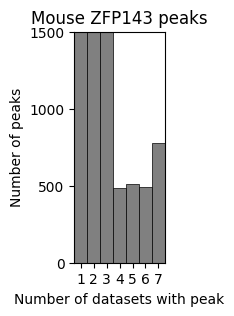

In [9]:
plt.figure(figsize = (5*7/30, 3))
plt.title('Mouse ZFP143 peaks', fontsize = 12)
plt.bar(np.unique(mouse_zfp143_peaks['total'], return_counts = 1)[0],
        np.unique(mouse_zfp143_peaks['total'], return_counts = 1)[1], 
        edgecolor = 'k', color = 'grey', linewidth = 0.5, width = 1)
plt.xlim((0.5, 7.5))
plt.ylim((0, 1500))
plt.xticks(np.arange(1, 8))
plt.yticks([0, 500, 1000, 1500])
plt.xlabel('Number of datasets with peak', fontsize = 10)
plt.ylabel('Number of peaks', fontsize = 10)
plt.show()

## Motifs in the peaks

In [11]:
fraction_peaks_with_motif = []
for dataset_number in np.arange(0, 7):
    fractions = mouse_zfp143_peaks[mouse_zfp143_peaks['total'] == dataset_number+1][['sbs1', 'sbs2', 'sbs1_and_sbs2']]
    count_sbs1_sbs2 = len(fractions[fractions['sbs1_and_sbs2'] == 1])
    count_sbs1 = len(fractions[(fractions['sbs1'] == 1) & (fractions['sbs1_and_sbs2'] != 1)])
    count_sbs2 = len(fractions[(fractions['sbs2'] == 1) & (fractions['sbs1_and_sbs2'] != 1)])
    counts_no_motif = len(fractions)-count_sbs1_sbs2-count_sbs1-count_sbs2
    fractions = [count_sbs1_sbs2, count_sbs1, count_sbs2, counts_no_motif]
    fractions = np.array(fractions)/np.sum(fractions)

    fraction_peaks_with_motif.append(fractions)
fraction_peaks_with_motif = pd.DataFrame({'Number_of_datasets': np.arange(0, 7)+1, 
                                          'SBS1_SBS2': [x[0] for x in fraction_peaks_with_motif],
                                          'SBS1': [x[1] for x in fraction_peaks_with_motif],
                                          'SBS2': [x[2] for x in fraction_peaks_with_motif],
                                          'No_motif': [x[3] for x in fraction_peaks_with_motif]})
fraction_peaks_with_motif.head()

,Number_of_datasets,SBS1_SBS2,SBS1,SBS2,No_motif
0,1,0.059147,0.320093,0.028199,0.592562
1,2,0.080909,0.459834,0.027740,0.431516
2,3,0.164514,0.490174,0.029759,0.315553
3,4,0.192547,0.503106,0.020704,0.283644
4,5,0.565558,0.285714,0.052838,0.095890


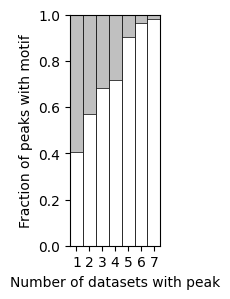

In [12]:
plt.figure(figsize = (5*7/30, 3))
plt.bar(fraction_peaks_with_motif['Number_of_datasets'], 
        fraction_peaks_with_motif['SBS1_SBS2']+fraction_peaks_with_motif['SBS1']+fraction_peaks_with_motif['SBS2']+fraction_peaks_with_motif['No_motif'], 
        edgecolor = 'k', width = 1, linewidth = 0.5, color = 'silver')
plt.bar(fraction_peaks_with_motif['Number_of_datasets'], 
        fraction_peaks_with_motif['SBS1_SBS2']+fraction_peaks_with_motif['SBS1']+fraction_peaks_with_motif['SBS2'], 
        edgecolor = 'k', width = 1, linewidth = 0.5, color = 'w')
plt.xlabel('Number of datasets with peak', fontsize = 10)
plt.ylabel('Fraction of peaks with motif', fontsize = 10)
plt.xticks(np.arange(1, 8))
plt.xlim((0.5, 7.5))
plt.ylim((0, 1))
plt.show()

## Category of peaks

In [13]:
fraction_peaks = []
for dataset_number in np.arange(0, 7):
    fractions = mouse_zfp143_peaks[mouse_zfp143_peaks['total'] == dataset_number+1][['cell_line_specific', 'conserved', 'total']]
    count_cell_line_specific = len(fractions[fractions['cell_line_specific'] == 1])
    count_conserved = len(fractions[fractions['conserved'] == 1])
    count_shared = len(fractions)-count_conserved-count_cell_line_specific
    fractions = [count_cell_line_specific, count_shared, count_conserved]
    fractions = np.array(fractions)/np.sum(fractions)

    fraction_peaks.append(fractions)
fraction_peaks = pd.DataFrame({'Number_of_datasets': np.arange(0, 7)+1, 
                               'Cell_line_specific': [x[0] for x in fraction_peaks],
                               'Shared': [x[1] for x in fraction_peaks],
                               'Conserved': [x[2] for x in fraction_peaks]})
fraction_peaks.head()

,Number_of_datasets,Cell_line_specific,Shared,Conserved
0,1,1.000000,0.000000,0.000000
1,2,0.672125,0.327875,0.000000
2,3,0.000000,1.000000,0.000000
3,4,0.000000,1.000000,0.000000
4,5,0.000000,0.968689,0.031311


Cell-line-specific: 26398
Shared (2-4 cell lines): 4503
Conserved (5 cell lines): 1240


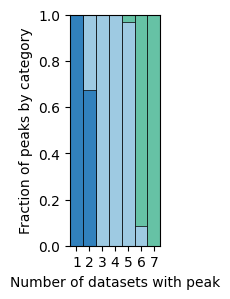

In [14]:
cell_line_specific = len(mouse_zfp143_peaks[mouse_zfp143_peaks['cell_line_specific'] == 1])
conserved_num = len(mouse_zfp143_peaks[mouse_zfp143_peaks['conserved'] == 1])
shared_num = len(mouse_zfp143_peaks)-cell_line_specific-conserved_num
print('Cell-line-specific:', cell_line_specific)
print('Shared (2-4 cell lines):', shared_num)
print('Conserved (5 cell lines):', conserved_num)

plt.figure(figsize = (5*7/30, 3))
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Cell_line_specific']+fraction_peaks['Shared']+fraction_peaks['Conserved'],
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#66C2A5')
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Cell_line_specific']+fraction_peaks['Shared'], 
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#9ECAE2')
plt.bar(fraction_peaks['Number_of_datasets'], 
        fraction_peaks['Cell_line_specific'], 
        edgecolor = 'k', width = 1, linewidth = 0.5, color = '#3181BD')

plt.xlabel('Number of datasets with peak', fontsize = 10)
plt.ylabel('Fraction of peaks by category', fontsize = 10)
plt.xticks(np.arange(1, 8))
plt.xlim((0.5, 7.5))
plt.ylim((0, 1))
plt.show()

## Assign conserved ZFP143 peaks to target genes

In [19]:
conserved_znf143_peaks = mouse_zfp143_peaks[mouse_zfp143_peaks['conserved'] == 1][['chrom', 'start', 'end']]
conserved_znf143_peaks['name'] = ['ZFP143_conserved_' + str(i+1) for i in range(len(conserved_znf143_peaks))]
print('Number of conserved peaks:', len(conserved_znf143_peaks))

conserved_znf143_peaks.head()

Number of conserved peaks: 1240


,chrom,start,end,name
22,chr1,6214323,6214967,ZFP143_conserved_1
34,chr1,9544986,9545865,ZFP143_conserved_2
38,chr1,9700328,9700892,ZFP143_conserved_3
39,chr1,9748066,9748811,ZFP143_conserved_4
80,chr1,16104142,16105573,ZFP143_conserved_5


In [20]:
motifs_sbs1 = pd.read_csv('./conserved_genes/ZFP143_SBS1_denovo_motifs.mm10.bed', sep = '\t', header = None)
motifs_sbs1.columns = ['chrom', 'start', 'end', 'name', 'strand', 'score']
motifs_sbs1 = motifs_sbs1[['chrom', 'start', 'end', 'name', 'score', 'strand']]

motifs_sbs2 = pd.read_csv('./conserved_genes/ZFP143_SBS2_denovo_motifs.mm10.bed', sep = '\t', header = None)
motifs_sbs2.columns = ['chrom', 'start', 'end', 'name', 'strand', 'score']
motifs_sbs2 = motifs_sbs2[['chrom', 'start', 'end', 'name', 'score', 'strand']]

In [21]:
peaks_overlap_sbs1 = bioframe.overlap(conserved_znf143_peaks, motifs_sbs1, suffixes=('', '_sbs1')).dropna()
peaks_overlap_sbs2 = bioframe.overlap(conserved_znf143_peaks, motifs_sbs2, suffixes=('', '_sbs2')).dropna()
peaks_with_sbs1 = list(np.unique(peaks_overlap_sbs1['name']))
peaks_with_sbs2 = list(np.unique(peaks_overlap_sbs2['name']))
peaks_with_sbs1_and_sbs2 = list(set.intersection(set(peaks_with_sbs1), set(peaks_with_sbs2)))
peaks_only_sbs1 = [x for x in peaks_with_sbs1 if x not in peaks_with_sbs2]
peaks_only_sbs2 = [x for x in peaks_with_sbs2 if x not in peaks_with_sbs1]

peaks_overlap_sbs1_sbs2 = bioframe.overlap(bioframe.overlap(conserved_znf143_peaks, motifs_sbs1, suffixes=('', '_sbs1')), motifs_sbs2, suffixes=('', '_sbs2'))
peaks_with_overlapping_sbs1_and_sbs2 = []
for peak in peaks_with_sbs1_and_sbs2:
    peak_motif_pairs = peaks_overlap_sbs1_sbs2[peaks_overlap_sbs1_sbs2['name'] == peak]
    for pair in peak_motif_pairs.values:
        start_sbs1, end_sbs1, start_sbs2, end_sbs2 = pair[5], pair[6], pair[11], pair[12]
        if max(start_sbs1, start_sbs2) <= min(end_sbs1, end_sbs2):
            peaks_with_overlapping_sbs1_and_sbs2.append(peak)
            break

print('SBS1 or SBS2:', len(np.unique(np.hstack((peaks_with_sbs1, peaks_with_sbs2)))) / len(conserved_znf143_peaks) * 100)
print('SBS1 and SBS2:', len(peaks_with_sbs1_and_sbs2) / len(conserved_znf143_peaks) * 100)
print('SBS1 and SBS2 (overlapping):', len(peaks_with_overlapping_sbs1_and_sbs2) / len(conserved_znf143_peaks) * 100)
print('SBS1 only:', len(peaks_only_sbs1) / len(np.unique(conserved_znf143_peaks['name'])) * 100)
print('SBS2 only:', len(peaks_only_sbs2) / len(np.unique(conserved_znf143_peaks['name'])) * 100)

SBS1 or SBS2: 97.5
SBS1 and SBS2: 63.064516129032256
SBS1 and SBS2 (overlapping): 57.983870967741936
SBS1 only: 32.41935483870968
SBS2 only: 2.0161290322580645


In [22]:
# Read GTF with comprehensive gene annotation
genes = read_gtf('/DATA/users/magnitov/znf143/genome/gencode.vM25.annotation.gtf')

# Filter transcripts of protein coding or long non-coding RNAs with high confidence
genes = genes[genes['feature'] == 'transcript']
genes = genes[genes['transcript_support_level'].isin(['1', '2', '3', '4', '5'])]
genes = genes[genes['transcript_type'].isin(['protein_coding', 'lincRNA', 'processed_transcript', 'bidirectional_promoter_lncRNA', 'antisense'])]

genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_name', 'gene_type', 'transcript_id', 'transcript_type', 'transcript_support_level']]
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


,seqname,start,end,strand,gene_id,gene_name,gene_type,transcript_id,transcript_type,transcript_support_level
7,chr1,3205901,3216344,-,ENSMUSG00000051951.5,Xkr4,protein_coding,ENSMUST00000162897.1,processed_transcript,1
10,chr1,3206523,3215632,-,ENSMUSG00000051951.5,Xkr4,protein_coding,ENSMUST00000159265.1,processed_transcript,1
13,chr1,3214482,3671498,-,ENSMUSG00000051951.5,Xkr4,protein_coding,ENSMUST00000070533.4,protein_coding,1
37,chr1,3466587,3513553,+,ENSMUSG00000089699.1,Gm1992,antisense,ENSMUST00000161581.1,antisense,3
63,chr1,3905739,3986215,-,ENSMUSG00000102343.1,Gm37381,lincRNA,ENSMUST00000194643.1,lincRNA,3


In [23]:
def get_tss(genes, margin_upstream, margin_downstream):
    genes_tss = []
    for gene in genes.values:
        if gene[3] == '+':
            genes_tss.append([gene[0], gene[1]-margin_upstream, gene[1]+margin_downstream, gene[4], gene[5], gene[3], gene[6], gene[7], gene[8], gene[9]])
        else:
            genes_tss.append([gene[0], gene[2]-margin_downstream, gene[2]+margin_upstream, gene[4], gene[5], gene[3], gene[6], gene[7], gene[8], gene[9]])

    genes_tss = pd.DataFrame(genes_tss)
    genes_tss.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand', 'gene_type', 'transcript_id', 'transcript_type', 'transcript_support']
    return(genes_tss)

In [24]:
# Find overlap between peaks and TSS regions
peaks_overlap_genes = bioframe.overlap(conserved_znf143_peaks, get_tss(genes, 2000, 1000), suffixes=('', '_genes'))
peaks_overlap_genes = peaks_overlap_genes.drop(['chrom_genes'], axis = 1).dropna()
peaks_overlap_genes['strand_genes'] = [str(x) for x in peaks_overlap_genes['strand_genes']]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [25]:
# Replace transcript coordinates with actual coordinates instead of widened TSS coordinates
peaks_overlap_genes = peaks_overlap_genes.merge(genes, left_on = 'transcript_id_genes', right_on = 'transcript_id')
peaks_overlap_genes = peaks_overlap_genes.drop(['seqname', 'strand', 'gene_id', 'transcript_id', 
                                                'gene_name', 'gene_type', 'transcript_type', 'transcript_support_level'], axis = 1)
peaks_overlap_genes['start_genes'] = peaks_overlap_genes['start_y']
peaks_overlap_genes['end_genes'] = peaks_overlap_genes['end_y']
peaks_overlap_genes = peaks_overlap_genes.drop(['start_y', 'end_y'], axis = 1)
peaks_overlap_genes.columns = ['chrom', 'start_peak', 'end_peak', 'name_peak',
                               'start_gene', 'end_gene', 'gene_id', 'gene_name', 'strand_gene', 'gene_type', 
                               'transcript_id', 'transcript_type', 'transcript_support']

In [26]:
# Add distance between transcript and center of the peak
distances = []
for peak_transcript_pair in peaks_overlap_genes.values:
    if peak_transcript_pair[8] == '+':
        distances.append(peak_transcript_pair[4] - (peak_transcript_pair[1]+peak_transcript_pair[2])//2)
    else:
        distances.append(peak_transcript_pair[5] - (peak_transcript_pair[1]+peak_transcript_pair[2])//2)
peaks_overlap_genes['distance'] = [abs(x) for x in distances]
peaks_overlap_genes = peaks_overlap_genes[peaks_overlap_genes['distance'] <= 2000]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [27]:
# For each gene find the transcript with highest (i) transcript support level, (ii) distance to peak, (iii) length
indices_to_keep = []
for gene_id in np.unique(peaks_overlap_genes['gene_id']):
    overlaps_gene = peaks_overlap_genes[peaks_overlap_genes['gene_id'] == gene_id]
    overlaps_gene['length'] = overlaps_gene['end_gene']-overlaps_gene['start_gene']
    if len(overlaps_gene) == 1:
        indices_to_keep.append(overlaps_gene.index[0])
    else:
        ranked_transcripts = overlaps_gene.sort_values(['transcript_support', 'distance', 'length'], ascending = [1, 1, 0])
        indices_to_keep.append(ranked_transcripts.index[0])

peaks_overlap_genes = peaks_overlap_genes.iloc[np.sort(indices_to_keep)]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [28]:
# For peaks that were associated with multiple genes on same strand, try to find more appropriate one based on
# (i) transcript type, (ii) transcript support level and (iii) presence of genes with lower confidence at the same location
indices_to_remove = []
for peak in np.unique(peaks_overlap_genes['name_peak']):
    peak_genes = peaks_overlap_genes[peaks_overlap_genes['name_peak'] == peak]
    
    if (len(peak_genes[peak_genes['strand_gene'] == '+']) > 1) or (len(peak_genes[peak_genes['strand_gene'] == '-']) > 1):
        if (len(peak_genes[peak_genes['strand_gene'] == '+']) > 1):
            ambiguous_pairs = peak_genes[peak_genes['strand_gene'] == '+'][['gene_name', 'chrom', 'start_gene', 'end_gene', 'strand_gene', 'transcript_type', 'transcript_support', 'distance']]
        else:
            ambiguous_pairs = peak_genes[peak_genes['strand_gene'] == '-'][['gene_name', 'chrom', 'start_gene', 'end_gene', 'strand_gene', 'transcript_type', 'transcript_support', 'distance']]
        
        ambiguous_indices = ambiguous_pairs.index

        if len(ambiguous_pairs[ambiguous_pairs['transcript_type'].isin(['protein_coding', 'lincRNA'])]) > 0 and len(ambiguous_pairs) > 1:
            ambiguous_pairs = ambiguous_pairs[ambiguous_pairs['transcript_type'].isin(['protein_coding', 'lincRNA'])]
        if len(ambiguous_pairs[ambiguous_pairs['transcript_support'].isin(['1', '2'])]) > 0 and len(ambiguous_pairs) > 1:
            ambiguous_pairs = ambiguous_pairs[ambiguous_pairs['transcript_support'].isin(['1', '2'])]    
        ambiguous_indices = [x for x in ambiguous_indices if x not in ambiguous_pairs.index]
        indices_to_remove = indices_to_remove + ambiguous_indices

peaks_overlap_genes = peaks_overlap_genes.drop(indices_to_remove)
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [29]:
# Add information about SBS1 or SBS2 motif presense in the peak
has_sbs1_motif_same_orientation, has_sbs2_motif_same_orientation = [], []
for peak_gene_pair in peaks_overlap_genes.values:
    motifs_associated_with_peak = peaks_overlap_sbs1_sbs2[peaks_overlap_sbs1_sbs2['name'] == peak_gene_pair[3]]
    
    gene_strand = peak_gene_pair[8]
    if gene_strand in motifs_associated_with_peak['strand_sbs1'].values:
        has_sbs1_motif_same_orientation.append(1)
    else:
        has_sbs1_motif_same_orientation.append(0)
        
    if gene_strand in motifs_associated_with_peak['strand_sbs2'].values:
        has_sbs2_motif_same_orientation.append(1)
    else:
        has_sbs2_motif_same_orientation.append(0)
        
peaks_overlap_genes['sbs1_motif'] = has_sbs1_motif_same_orientation
peaks_overlap_genes['sbs2_motif'] = has_sbs2_motif_same_orientation
peaks_overlap_genes['sbs1_and_sbs2_motif'] = [1 if x+y==2 else 0 for (x, y) in zip(peaks_overlap_genes['sbs1_motif'], peaks_overlap_genes['sbs2_motif'])]

In [31]:
peaks_overlap_genes.to_csv('./conserved_genes/conserved_ZFP143_peaks_GENCODE_genes_associations.txt', sep = '\t', header = 1, index = 0)

## Statistics for the final set of associations

In [34]:
print('Number of peaks associated:', len(np.unique(peaks_overlap_genes['name_peak'])), 
      '(' + str(round(len(np.unique(peaks_overlap_genes['name_peak']))/len(conserved_znf143_peaks)*100, 1)) + '% of peaks)')

unidirectional, bidirectional = 0, 0

for peak in np.unique(peaks_overlap_genes['name_peak']):
    peak_genes = peaks_overlap_genes[peaks_overlap_genes['name_peak'] == peak]
    if '+' in peak_genes['strand_gene'].values and '-' in peak_genes['strand_gene'].values:
        bidirectional += 1
    else:
        unidirectional += 1

print('Peaks associated with unidirectional promoters:', unidirectional,
      '(' + str(round(unidirectional/len(np.unique(peaks_overlap_genes['name_peak']))*100, 2)) + '%)')
print('Peaks associated with bidirectional promoters:', bidirectional, 
      '(' + str(round(bidirectional/len(np.unique(peaks_overlap_genes['name_peak']))*100, 2)) + '%)')

Number of peaks associated: 1169 (94.3% of peaks)
Peaks associated with unidirectional promoters: 843 (72.11%)
Peaks associated with bidirectional promoters: 326 (27.89%)


In [35]:
print('Number of genes associated:', len(np.unique(peaks_overlap_genes['gene_id'])))

gene_types_associated = pd.DataFrame(np.unique(peaks_overlap_genes['transcript_type'], return_counts = 1))
gene_types_associated = gene_types_associated.transpose().sort_values([1], ascending = 0)
gene_types_associated[2] = gene_types_associated[1] / np.sum(gene_types_associated[1])
gene_types_associated.columns = ['transcript_type', 'number_of_transcripts', 'fraction']
gene_types_associated

Number of genes associated: 1504


,transcript_type,number_of_transcripts,fraction
4,protein_coding,1348,0.896277
3,processed_transcript,61,0.040559
0,antisense,50,0.033245
2,lincRNA,39,0.025931
1,bidirectional_promoter_lncRNA,6,0.003989
